In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.stats.api import ols
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.decomposition import PCA

C:\Users\Shane Hunsberger\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First we have to import the data into a pandas DataFrame

In [2]:
vg = pd.read_csv('vg_data.csv')

We check that the data looks correct by looking at the head

In [3]:
vg.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


Then we use .info to take a deeper look into the data and see if there are issues

In [4]:
vg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16598 non-null int64
Name            16598 non-null object
Platform        16598 non-null object
Year            16327 non-null float64
Genre           16598 non-null object
Publisher       16540 non-null object
NA_Sales        16598 non-null float64
EU_Sales        16598 non-null float64
JP_Sales        16598 non-null float64
Other_Sales     16598 non-null float64
Global_Sales    16598 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Let's analyze the data to see what we have to fix

In [5]:
total = vg.isnull().sum().sort_values(ascending=False)
percent = (vg.isnull().sum()/vg.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Null', 'Percent Null'])
missing_data.head()

,Total Null,Percent Null
Year,271,0.016327
Publisher,58,0.003494
Global_Sales,0,0.000000
Other_Sales,0,0.000000
JP_Sales,0,0.000000


From this we see that the year is null for 271 entries out of 16598 and Publisher is null for 58 entries out of 16598.

Often we would solve this using mean value imputation like so:

vg["Year"][pd.isnull(vg["Year"]) == True] =  np.nanmean(vg["Year])

However, imputing a mean value for year doesn't really make sense.  

Publisher also there is nothing we can do short off looking up the publisher for the missing entries.

Because there is no effective remedy & the bad data is such a small fraction of the data, we drop any values that are filled with 'None' or 'NaN'

In [6]:
games = vg.dropna()

Then check .info again to see if the numbers are at least now consistent

In [7]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16291 non-null int64
Name            16291 non-null object
Platform        16291 non-null object
Year            16291 non-null float64
Genre           16291 non-null object
Publisher       16291 non-null object
NA_Sales        16291 non-null float64
EU_Sales        16291 non-null float64
JP_Sales        16291 non-null float64
Other_Sales     16291 non-null float64
Global_Sales    16291 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Now that we have 16,291 entries for each attribute, we can look into the attribute data to see if there are any glaring outliers

In [8]:
games.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000
mean,8290.190228,2006.405561,0.265647,0.147731,0.078833,0.048426,0.540910
std,4792.654450,5.832412,0.822432,0.509303,0.311879,0.190083,1.567345
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4132.500000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8292.000000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12439.500000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


Since it is currently 2017 and the data set is from 2016, we know that the max of 2020 is an error. It is either due to the name of the game having 2020 or an entry error. To remedy this, we will remove anything with a year over 2016. 

In [9]:
cleaned_games = games.loc[games['Year'] < 2017, :]

In [10]:
cleaned_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16287 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16287 non-null int64
Name            16287 non-null object
Platform        16287 non-null object
Year            16287 non-null float64
Genre           16287 non-null object
Publisher       16287 non-null object
NA_Sales        16287 non-null float64
EU_Sales        16287 non-null float64
JP_Sales        16287 non-null float64
Other_Sales     16287 non-null float64
Global_Sales    16287 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [11]:
cleaned_games.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000,16287.000000
mean,8288.969853,2006.402775,0.265695,0.147768,0.078849,0.048437,0.541022
std,4792.138597,5.830382,0.822525,0.509360,0.311916,0.190105,1.567520
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4131.500000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8291.000000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12437.500000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,16600.000000,2016.000000,41.490000,29.020000,10.220000,10.570000,82.740000


And after all the cleaning, we now apply the same null tests we did up top and everything is clean

In [12]:
total = cleaned_games.isnull().sum().sort_values(ascending=False)
percent = (cleaned_games.isnull().sum()/cleaned_games.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Null', 'Percent Null'])
missing_data.head()

,Total Null,Percent Null
Global_Sales,0,0.0
Other_Sales,0,0.0
JP_Sales,0,0.0
EU_Sales,0,0.0
NA_Sales,0,0.0


Now lets see what genres are the most popular just in aggreate?

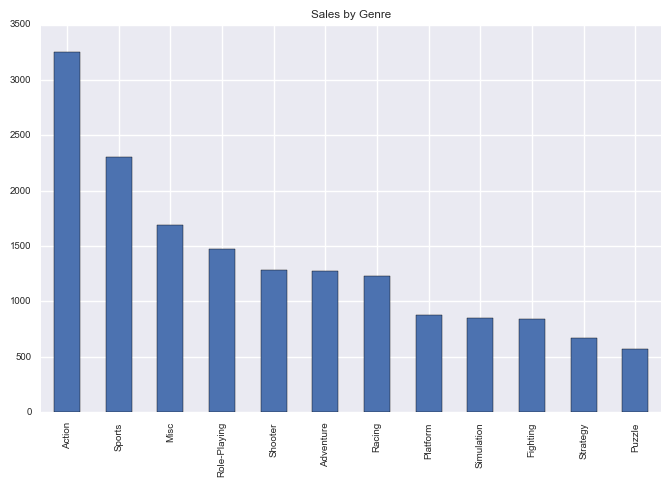

In [21]:
fig,ax = plt.subplots(figsize=(8,5))
cleaned_games['Genre'].value_counts(sort=True).plot(kind='bar')
plt.title('Sales by Genre')

Yep, action and sports are the two most popular genres, violence and sports.

Now let's look at most popular platforms...

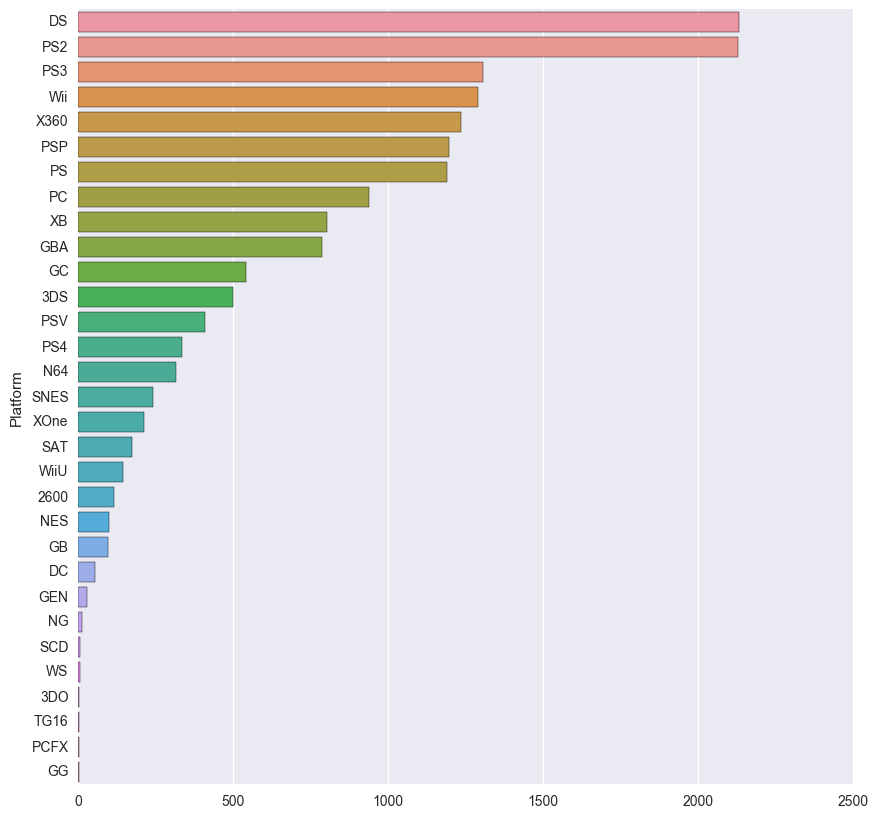

In [14]:
platGenre = pd.crosstab(cleaned_games.Platform,cleaned_games.Genre)
platGenreTotal = platGenre.sum(axis=1).sort_values(ascending = False)
plt.figure(figsize=(10,10))
sns.barplot(y = platGenreTotal.index, x = platGenreTotal.values, orient='h')
plt.ylabel = "Platform"
plt.xlabel = "Total games"
plt.show()

It's PS2 and DS in the lead by number of titles

Let's go a little bit deeper...within the different platforms what is the breakdown of the genres?


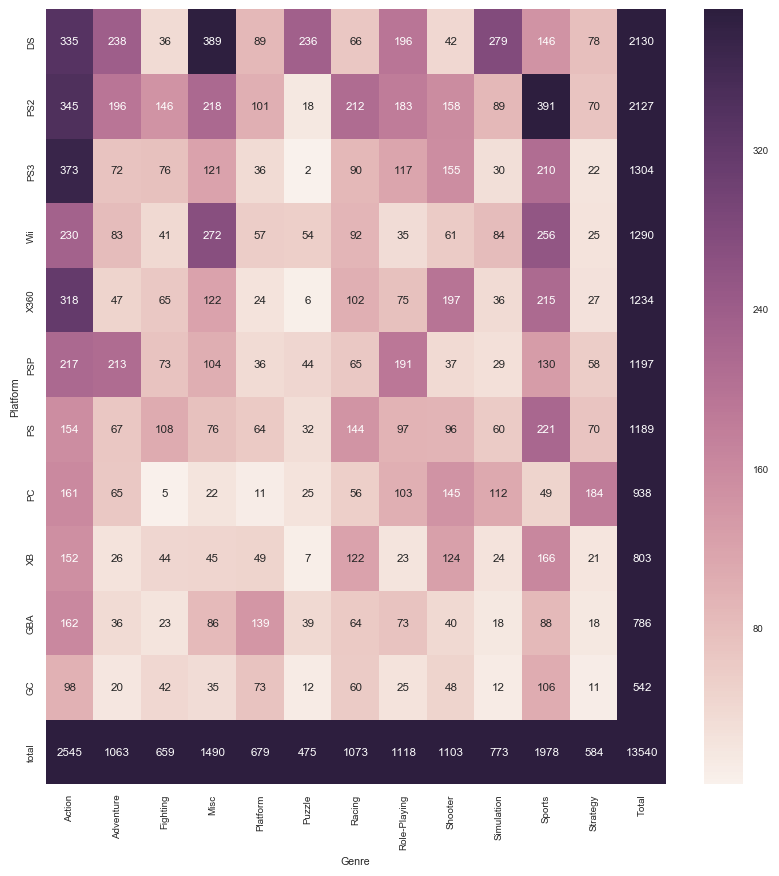

In [15]:
platGenre['Total'] = platGenre.sum(axis=1)
popPlatform = platGenre[platGenre['Total']>500].sort_values(by='Total', ascending = False)
neededdata = popPlatform.loc[:,:'Strategy']
maxi = neededdata.values.max()
mini = neededdata.values.min()
popPlatformfinal = popPlatform.append(pd.DataFrame(popPlatform.sum(), columns=['total']).T, ignore_index=False)
sns.set(font_scale=0.7)
plt.figure(figsize=(10,10))
sns.heatmap(popPlatformfinal, vmin = mini, vmax = maxi, annot=True, fmt="d")
plt.xticks(rotation = 90)
plt.show()

This shows us an interesting result, the the most popular genre is different for different plaforms.

For DS the most popular genre is miscellaneous, for PS2 the most popular genre is strategy, and forPS3 the most popular genre is action.

Our next question is how do sales vary by genre by region?


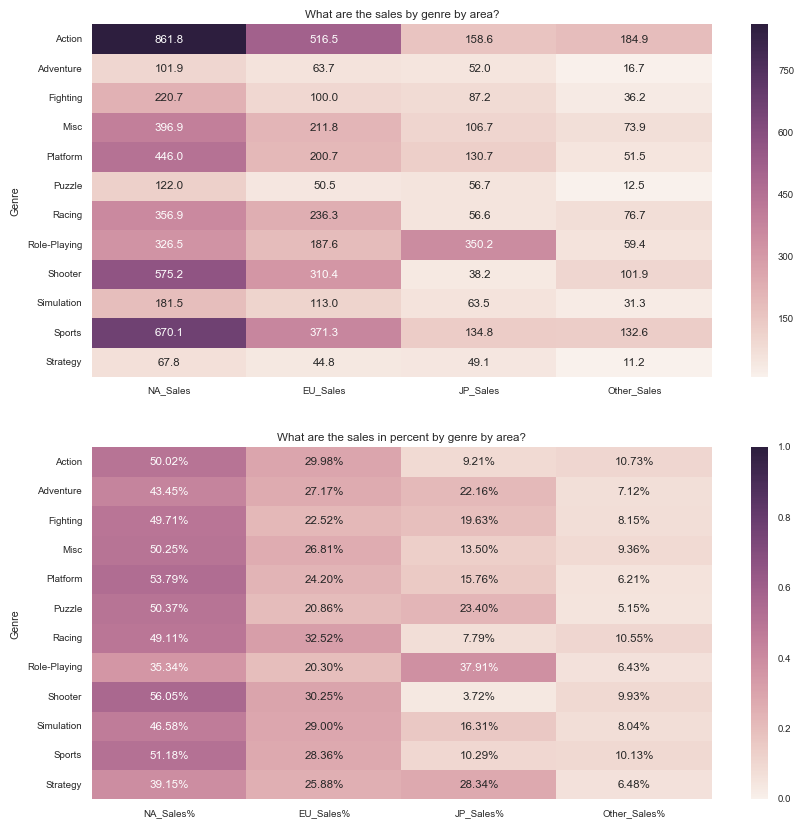

In [22]:
GenreGroup = cleaned_games.groupby(['Genre']).sum().loc[:, 'NA_Sales':'Global_Sales']
GenreGroup['NA_Sales%'] = GenreGroup['NA_Sales']/GenreGroup['Global_Sales']
GenreGroup['EU_Sales%'] = GenreGroup['EU_Sales']/GenreGroup['Global_Sales']
GenreGroup['JP_Sales%'] = GenreGroup['JP_Sales']/GenreGroup['Global_Sales']
GenreGroup['Other_Sales%'] = GenreGroup['Other_Sales']/GenreGroup['Global_Sales']
plt.figure(figsize=(10, 10))
sns.set(font_scale=0.7)
plt.subplot(211)
sns.heatmap(GenreGroup.loc[:, 'NA_Sales':'Other_Sales'], annot=True, fmt = '.1f')
plt.title("What are the sales by genre by area?")
plt.subplot(212)
sns.heatmap(GenreGroup.loc[:,'NA_Sales%':'Other_Sales%'], vmax =1, vmin=0, annot=True, fmt = '.2%')
plt.title("What are the sales in percent by genre by area?")
plt.show()

What stands out here is that how popular role playing games are in Japan.

Now let's see how our different factors correlate with Global Sales?

In [23]:
games_corr = cleaned_games.corr(method='pearson')['Global_Sales']
print(games_corr)

Rank           -0.426987
Year           -0.074548
NA_Sales        0.941269
EU_Sales        0.903262
JP_Sales        0.612770
Other_Sales     0.747960
Global_Sales    1.000000
Name: Global_Sales, dtype: float64


The sales of the different regions are clearly correlated like they should be because global sales is the sum of the region sales.  Looking at this holistically:

In [24]:
cleaned_games.corr(method='pearson')  

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,1.000000,0.177705,-0.400319,-0.379155,-0.269336,-0.332746,-0.426987
Year,0.177705,1.000000,-0.091221,0.006250,-0.169365,0.041255,-0.074548
NA_Sales,-0.400319,-0.091221,1.000000,0.768921,0.451279,0.634514,0.941269
EU_Sales,-0.379155,0.006250,0.768921,1.000000,0.436371,0.726252,0.903262
JP_Sales,-0.269336,-0.169365,0.451279,0.436371,1.000000,0.290551,0.612770
Other_Sales,-0.332746,0.041255,0.634514,0.726252,0.290551,1.000000,0.747960
Global_Sales,-0.426987,-0.074548,0.941269,0.903262,0.612770,0.747960,1.000000


It is clear that the Japan region is unique from North America and Europe.

But these variables are really predictive of global sales....they are the very definition of multicollinear...global sales is the sum of the region sales.

What would be interesting is to use see how predictive of sales the genres are....to this end we'll create a new data set with dummy variables for the genres

In [25]:
Global_ols_cleaned_games = cleaned_games#copies over our original data to a new variable

if 'Genre' in Global_ols_cleaned_games.columns:
    Global_ols_cleaned_games = pd.get_dummies(cleaned_games,columns= ['Genre'], drop_first=True)#creates dummy variables that can be used in later regression

# if 'Platform' in Global_ols_cleaned_games.columns:
#     Global_ols_cleaned_games = pd.get_dummies(cleaned_games,columns= ['Platform'], drop_first=True)#creates dummy variables that can be used in later regression
   
Global_ols_cleaned_games['Global_Sales'] = cleaned_games['Global_Sales']#Add dependent variable 

Global_ols_cleaned_games.head()#check the data

,Rank,Name,Platform,Year,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,1,Wii Sports,Wii,2006.0,Nintendo,41.49,29.02,3.77,8.46,82.74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,Super Mario Bros.,NES,1985.0,Nintendo,29.08,3.58,6.81,0.77,40.24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Mario Kart Wii,Wii,2008.0,Nintendo,15.85,12.88,3.79,3.31,35.82,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,Wii Sports Resort,Wii,2009.0,Nintendo,15.75,11.01,3.28,2.96,33.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Nintendo,11.27,8.89,10.22,1.00,31.37,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Now that we have our dummy variables set for genres, let's split this up into traing and tests sets...

In [26]:
Global_train, Global_test = train_test_split(Global_ols_cleaned_games, test_size = 0.3, random_state = 1) #creates the training and test data for
#x and y using 30% of the data (randomly chosen) as the test data. This is for global sales

# Regression for global sales using an OLS model

In [27]:
Train_Global_games_ols = ols(y=Global_train['Global_Sales'], x=Global_train[['Year','Genre_Misc', 'Genre_Adventure', 'Genre_Fighting', 'Genre_Platform', 'Genre_Puzzle','Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy']])

Train_Global_games_ols

C:\Users\Shane Hunsberger\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)



-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Year> + <Genre_Misc> + <Genre_Adventure> + <Genre_Fighting>
             + <Genre_Platform> + <Genre_Puzzle> + <Genre_Racing>
             + <Genre_Role-Playing> + <Genre_Shooter> + <Genre_Simulation> + <Genre_Sports>
             + <Genre_Strategy> + <intercept>

Number of Observations:         11400
Number of Degrees of Freedom:   13

R-squared:         0.0159
Adj R-squared:     0.0148

Rmse:              1.6199

F-stat (12, 11387):    15.3081, p-value:     0.0000

Degrees of Freedom: model 12, resid 11387

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          Year    -0.0173     0.0027      -6.50     0.0000    -0.0225    -0.0121
    Genre_Misc    -0.0542     0.0583      -0.93     0.3530    -0

# Validating using test data

In [28]:
Test_Global_games_ols = ols(y=Global_test['Global_Sales'], x=Global_test[['Genre_Misc', 'Genre_Adventure', 'Genre_Fighting', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy']])

Test_Global_games_ols

C:\Users\Shane Hunsberger\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)



-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Genre_Misc> + <Genre_Adventure> + <Genre_Fighting>
             + <Genre_Platform> + <Genre_Puzzle> + <Genre_Racing> + <Genre_Role-Playing>
             + <Genre_Shooter> + <Genre_Simulation> + <Genre_Sports> + <Genre_Strategy>
             + <intercept>

Number of Observations:         4887
Number of Degrees of Freedom:   12

R-squared:         0.0133
Adj R-squared:     0.0111

Rmse:              1.3980

F-stat (11, 4875):     5.9780, p-value:     0.0000

Degrees of Freedom: model 11, resid 4875

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
    Genre_Misc    -0.1016     0.0760      -1.34     0.1815    -0.2505     0.0474
Genre_Adventure    -0.3902     0.0843      -4.63     0.0000    -0.5554    -0

Overall, not good.  Most variables have a terrible p-value and overall the adjusted R-squared is .0111, mean the genres explans about 1% of the variation in Global Sales.

Let's try this again with Lasso, Ridge, Lasso PCA, and Ridge PCA.  I'm already having bad flashbacks to the final.

Let's cleate a new data set, create dummy variables to represent the genres, drop the columns like publisher, platform, and name that aren't predictive.  (Although technically for Publisher you could create dummy variables which probably would be predictive, it's just there are too many publishers.)

In [29]:
X_Global_ols_cleaned_games = cleaned_games#copies over our original data to a new variable

X_Global_ols_cleaned_games = X_Global_ols_cleaned_games.drop('Publisher', axis = 1)
X_Global_ols_cleaned_games = X_Global_ols_cleaned_games.drop('Platform', axis = 1)
X_Global_ols_cleaned_games = X_Global_ols_cleaned_games.drop('Name', axis = 1)
if 'Genre' in X_Global_ols_cleaned_games.columns:
    X_Global_ols_cleaned_games = pd.get_dummies(X_Global_ols_cleaned_games,columns= ['Genre'], drop_first=True)#creates dummy variables that can be used in later regression
X_Global_ols_cleaned_games
Y_Global_ols_cleaned_games = cleaned_games['Global_Sales']
x_train, x_test, y_train, y_test = train_test_split(X_Global_ols_cleaned_games, Y_Global_ols_cleaned_games, test_size = 0.3, random_state = 1)
X_Global_ols_cleaned_games.head()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,1,2006.0,41.49,29.02,3.77,8.46,82.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1985.0,29.08,3.58,6.81,0.77,40.24,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2008.0,15.85,12.88,3.79,3.31,35.82,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,2009.0,15.75,11.01,3.28,2.96,33.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,1996.0,11.27,8.89,10.22,1.00,31.37,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [30]:
#create a parameter grid to find the best 'Hyperparameter'
#sets up the first part of the grid search as outlined it the scikit learn notes. This is where the parameters will come from
param_grid =  {'polynomialfeatures__degree':np.arange(2), 'lasso__alpha':[.1, .2, .3, .4, .5, .6, .7, .8, .9]}

#this is the model that the above paramets will be plugged into 50k times (100k seemed excessive)
Lasso_model = make_pipeline(StandardScaler(), PolynomialFeatures(), Lasso(max_iter = 50000))

LassoSearch = GridSearchCV(Lasso_model, param_grid, cv = 7)
LassoSearch.fit(x_train, y_train)#uses the fit method to set it up for the crossvalidation score

Lasso_train_score = cross_val_score(LassoSearch, x_train, y_train, cv=7)#using the best model, run it 7 times 

# Lasso Best Parameters

In [31]:
LassoSearch.best_params_ #This will find the parameters that best fit the model

{'lasso__alpha': 0.1, 'polynomialfeatures__degree': 1}

# Lasso Train Score

In [32]:
Lasso_train_score.mean() #then this will print out the mean of those scores to see how the model performed

0.99621031576170893

# Ridge Model

In [33]:
param_grid =  {'polynomialfeatures__degree':np.arange(2), 'ridge__alpha':[.1, .2, .3, .4, .5, .6, .7, .8, .9]}

Ridge_model = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge(max_iter = 50000))

RidgeSearch = GridSearchCV(Ridge_model, param_grid, cv = 7)
RidgeSearch.fit(x_train, y_train)

Ridge_train_score = cross_val_score(RidgeSearch, x_train, y_train, cv=7)#get seven cross validation scores

# Ridge Best Parameters

In [34]:
RidgeSearch.best_params_ #best parameters

{'polynomialfeatures__degree': 1, 'ridge__alpha': 0.1}

# Ridge Train Scores

In [35]:
Ridge_train_score.mean() #the mean of the scores

0.99999785698826371

# Lasso with PCA

In [36]:
param_grid =  {'polynomialfeatures__degree':np.arange(2), 'lasso__alpha':[.1, .2, .3, .4, .5, .6, .7, .8, .9], 'pca__n_components':[1, 3, 5, 7]}

Lasso_PCA_model = make_pipeline(StandardScaler(), PCA(), PolynomialFeatures(), Lasso(max_iter = 50000))

LassoPCASearch = GridSearchCV(Lasso_PCA_model, param_grid, cv = 7)
LassoPCASearch.fit(x_train, y_train)

Lasso_PCA_train_score = cross_val_score(LassoPCASearch, x_train, y_train, cv=7)

# Lasso PCA Best Parameters

In [39]:
LassoPCASearch.best_params_

{'lasso__alpha': 0.1, 'pca__n_components': 3, 'polynomialfeatures__degree': 1}

# Lasso PCA Train Scores

In [40]:
Lasso_PCA_train_score.mean()

0.96583292988014757

# Ridge with PCA

In [41]:
param_grid =  {'polynomialfeatures__degree':np.arange(2), 'ridge__alpha':[.1, .2, .3, .4, .5, .6, .7, .8, .9],'pca__n_components':[1, 3, 5, 7]}

Ridge_PCA_model = make_pipeline(StandardScaler(), PCA(), PolynomialFeatures(), Ridge(max_iter = 50000))

RidgePCASearch = GridSearchCV(Ridge_PCA_model, param_grid, cv = 7)
RidgePCASearch.fit(x_train, y_train)

Ridge_PCA_train_score = cross_val_score(RidgePCASearch, x_train, y_train, cv=7)#get seven cross validation scores

# Ridge PCA Best Parameters

In [42]:
RidgePCASearch.best_params_

{'pca__n_components': 7, 'polynomialfeatures__degree': 1, 'ridge__alpha': 0.9}

# Ridge PCA Train Scores

In [43]:
Ridge_PCA_train_score.mean()

0.97289878945220931

Now that we've calculated these scores, let's see them all together to compare. 

# Model Scores - Train

In [44]:
Lasso_train_score = cross_val_score(LassoSearch, x_train, y_train, cv=7)
print("Lasso: ", Lasso_train_score.mean())

Ridge_train_score = cross_val_score(RidgeSearch, x_train, y_train, cv=7)
print("Ridge: ",Ridge_train_score.mean())

Lasso_PCA_train_score = cross_val_score(LassoPCASearch, x_train, y_train, cv=7)
print("Lasso with PCA: ", Lasso_PCA_train_score.mean())

Ridge_PCA_train_score = cross_val_score(RidgePCASearch, x_train, y_train, cv=7)
print("Ridge with PCA: ", Ridge_PCA_train_score.mean())

print('OLS: ',Train_Global_games_ols)

Lasso:  0.996210315762
Ridge:  0.999997856988
Lasso with PCA:  0.965995600922
Ridge with PCA:  0.972898789452
OLS:  
-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Year> + <Genre_Misc> + <Genre_Adventure> + <Genre_Fighting>
             + <Genre_Platform> + <Genre_Puzzle> + <Genre_Racing>
             + <Genre_Role-Playing> + <Genre_Shooter> + <Genre_Simulation> + <Genre_Sports>
             + <Genre_Strategy> + <intercept>

Number of Observations:         11400
Number of Degrees of Freedom:   13

R-squared:         0.0159
Adj R-squared:     0.0148

Rmse:              1.6199

F-stat (12, 11387):    15.3081, p-value:     0.0000

Degrees of Freedom: model 12, resid 11387

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          Year    -0.0173    

Now with the test data

# Model Scores - Test

In [45]:
Lasso_test_score = cross_val_score(LassoSearch, x_test, y_test, cv=7)
print("Lasso: ", Lasso_test_score.mean())

Ridge_test_score = cross_val_score(RidgeSearch, x_test, y_test, cv=7)
print("Ridge: ",Ridge_test_score.mean())

Lasso_PCA_test_score = cross_val_score(LassoPCASearch, x_test, y_test, cv=7)
print("Lasso with PCA: ", Lasso_PCA_test_score.mean())

Ridge_PCA_test_score = cross_val_score(RidgePCASearch, x_test, y_test, cv=7)
print("Ridge with PCA: ", Ridge_PCA_test_score.mean())

print('OLS: ',Test_Global_games_ols)

Lasso:  0.994896205437
Ridge:  0.999995643535
Lasso with PCA:  0.952890658746
Ridge with PCA:  0.957766334454
OLS:  
-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Genre_Misc> + <Genre_Adventure> + <Genre_Fighting>
             + <Genre_Platform> + <Genre_Puzzle> + <Genre_Racing> + <Genre_Role-Playing>
             + <Genre_Shooter> + <Genre_Simulation> + <Genre_Sports> + <Genre_Strategy>
             + <intercept>

Number of Observations:         4887
Number of Degrees of Freedom:   12

R-squared:         0.0133
Adj R-squared:     0.0111

Rmse:              1.3980

F-stat (11, 4875):     5.9780, p-value:     0.0000

Degrees of Freedom: model 11, resid 4875

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
    Genre_Misc    -0.1016     0.0760     

Our best model is the Ridge model without PCA with a score of 0.999995643535 using the hyperparameters we found via the grid search of 'polynomialfeatures__degree': 1, 'ridge__alpha': 0.1